## Top-hat function advection

In [1]:
import matplotlib.pyplot as plt
import numpy as np

### 1. Define our domain (spatial discretisation):

In [2]:
# limits:
xmin = 0.
xmax = 1.

# Number of cells
nx = 256

# Number of ghost cells on each side
ng = 2

# Lowest and highest indices
ilo = ng
ihi = ng + nx - 1

# Step size
dx = (xmax - xmin)/(nx)

# X axis vector -> we need the cell centres:
x = xmin + (np.arange(nx + 2*ng) - ng + 0.5)*dx

#print(x)


### 2. Create vector to store solution array:

#### Include initial conditions: top-hat function in the middle

In [3]:
# Empty vector for the solution in double precision:
a = np.zeros((nx + 2*ng), dtype = np.float64)

# Add initial conditions;
a[:] = 0.
a[np.logical_and(x >= 1./3., x <= 2./3.)] = 1.

# Arrays to store different solutions
a1 = a.copy()
a2 = a.copy()
a3 = a.copy()
a4 = a.copy()

# Make a copy of the initial condition:
a0 = a.copy()

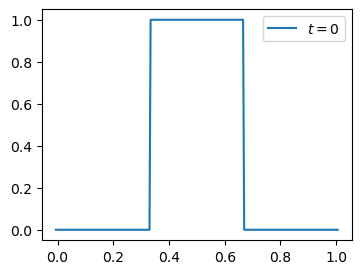

In [4]:
# Plotting the initial condition

plt.figure(figsize=(4,3))
plt.plot(x, a1, label = r"$t=0$")
plt.legend()
plt.show()

### 3. Time discretisation:

In [5]:
# Define perturbation velocity
u = 1.

# Define Courant number
C = 0.8

# Define number of periods
num_periods = 5.

# Calculate period 
period = (xmax - xmin)/u

# Maximmum simulation time
tmax = num_periods*period

In [6]:
# Functions for FLux limiters

# MinMod Function

def minmod(a, b):
    if abs(a) <= abs(b) and a*b > 0.0:
        return a
    if abs(b) <= abs(a) and a*b > 0.0:
        return b
    else:
        return 0.0

### 4. Evolution Loop



In [7]:
# Functions that will be called by the while statement

def fill_bcs(a):
    # Fill up the boundary conditions BCs
    for n in range(ng):
        # The left BC is
        a[ilo - 1 - n] = a[ihi - n]
        # The right BC is
        a[ihi + 1 + n] = a[ilo + n]
    return a

def states(a, dx, dt, method):
    
    # Empty vector for the slope
    slope = np.zeros((nx + 2*ng), dtype = np.float64)
    
    # This could be into a function
    
    if method == "godunov":
        # 1st approach: Godunov approach
        slope[:] = 0. 
    elif method == "unlimited":
        # 2nd approach: Centred difference method
        for i in range(ilo - 1, ihi + 2):
            slope[i] = 0.5*(a[i + 1] - a[i-1])/dx
    elif method == "minmod":  
        # 3rd approach: minmod limiter
        for i in range(ilo - 1, ihi + 2):
            slope[i] = minmod((a[i] - a[i-1])/dx, (a[i+1] - a[i])/dx) 
    elif method == "mc":
        # 4th approach: MC limiter
        for i in range(ilo - 1, ihi + 2):
            slope[i] = minmod(minmod(2*(a[i] - a[i-1])/dx, 2*(a[i+1]\
                       - a[i])/dx), 0.5*(a[i+1] - a[i-1])/dx) 
    
    # Empty vector dor the L and R states
    al = np.zeros((nx + 2*ng), dtype = np.float64)
    ar = np.zeros((nx + 2*ng), dtype = np.float64)
    
    # Add derivative calculation
    for i in range(ilo, ihi + 2):
        
        # Compute L state
        al[i] = a[i - 1] + 0.5*dx*(1. - u*dt/dx)*slope[i-1]
        
        # Compute R state
        ar[i] = a[i] - 0.5*dx*(1. + u*dt/dx)*slope[i]
        
    return al, ar
  
def riemann(al, ar):
    # Computing the flux
    if u > 0.:
        return u*al
    else: 
        return u*ar
    
def conservative_update(a, dt, flux):
    
    # Empty vector for updated solution
    anew = np.zeros((nx + 2*ng), dtype = np.float64)
    
    # Update
    anew[ilo:ihi+1] = a[ilo:ihi+1] -\
    dt/dx*(flux[ilo+1:ihi+2] - flux[ilo:ihi+1])
    
    # Return
    return anew

In [8]:
# While statement
# Initialise
t = 0.

# We start while:
while t < tmax:
    
    a1 = fill_bcs(a1)
    a2 = fill_bcs(a2)
    a3 = fill_bcs(a3)
    a4 = fill_bcs(a4)
    
    # Get time step
    dt = C*dx/u
    
    if t + dt > tmax:
        dt = tmax - t
    
    # Get interface states
    al1, ar1 = states(a1, dx, dt, "godunov")
    al2, ar2 = states(a2, dx, dt, "unlimited")
    al3, ar3 = states(a3, dx, dt, "minmod")
    al4, ar4 = states(a4, dx, dt, "mc")
    
    # Solve Riemann problem
    flux1 = riemann(al1, ar1)
    flux2 = riemann(al2, ar2)
    flux3 = riemann(al3, ar3)
    flux4 = riemann(al4, ar4)
    
    # Do the conservative update
    anew1 = conservative_update(a1, dt, flux1)
    anew2 = conservative_update(a2, dt, flux2)
    anew3 = conservative_update(a3, dt, flux3)
    anew4 = conservative_update(a4, dt, flux4)
    
    # Retrieve solution
    a1[:] = anew1[:]
    a2[:] = anew2[:]
    a3[:] = anew3[:]
    a4[:] = anew4[:]
    
    # Advance in time
    t += dt

### 5. Inspect solution:

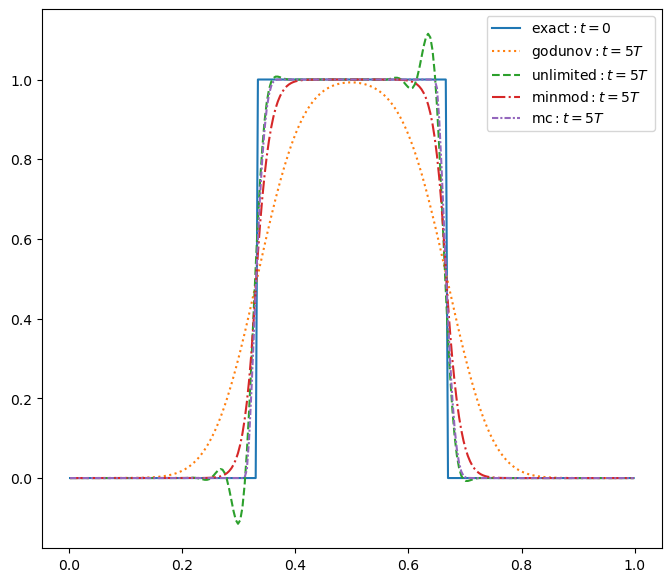

In [17]:
# Plotting the initial condition

plt.figure(figsize=(8,7))

plt.plot(x[ilo:ihi+1], a0[ilo:ihi+1], colour = "", linestyle = "-", label = r"${\rm exact}: t=0$")
plt.plot(x[ilo:ihi+1], a1[ilo:ihi+1], linestyle = ":", label = r"${\rm godunov}: t=5 T$")
plt.plot(x[ilo:ihi+1], a2[ilo:ihi+1], linestyle = "--", label = r"${\rm unlimited}: t=5 T$")
plt.plot(x[ilo:ihi+1], a3[ilo:ihi+1], linestyle = "-.", label = r"${\rm minmod}: t=5 T$")
plt.plot(x[ilo:ihi+1], a4[ilo:ihi+1], linestyle = (0, (3, 1, 1, 1)), label = r"${\rm mc}: t=5 T$")

plt.legend()
plt.show()